In [303]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle

In [300]:
T = 120
Rx = 1000
Ry = 1000
phi = 0.01
batch_size = 1_000

kappas = [0.2, 1., 5.]
sigmas = [0.2, 0.5, 1., 2.]
ps = [0.2, 0.5, 0.8]

In [301]:
results = dict()

for kappa in kappas:
    for sigma in sigmas:
        for p in ps:
            
            ''' Initial reserves '''
            Rx0   = np.array([Rx], float)
            Ry0   = np.array([Ry], float)

            ''' Fee rate '''
            phi0   = np.array([phi], float)

            pools = amm(Rx=Rx0, Ry=Ry0, phi=phi0)

            xs_0 = np.array([1.])
            l = pools.swap_and_mint(xs_0)
            end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate([kappa], [p], [sigma], T=T, batch_size=batch_size)
            
            """ Burn and swap all coins into x """
            x_T = np.zeros(batch_size)
            for k in range(batch_size):
                x_T[k] = np.sum(end_pools[k].burn_and_swap(l))

            x_0      = np.sum(xs_0)
            log_ret  = np.log(x_T) - np.log(x_0) # performance / log return

            results[(kappa, sigma, p)] = log_ret

100%|██████████| 1000/1000 [00:24<00:00, 40.42it/s]


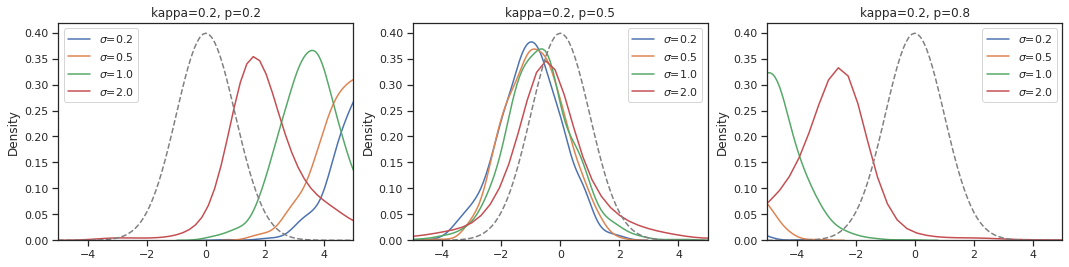

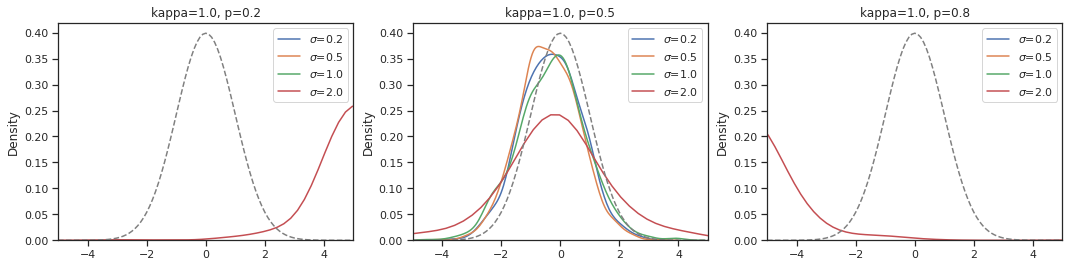

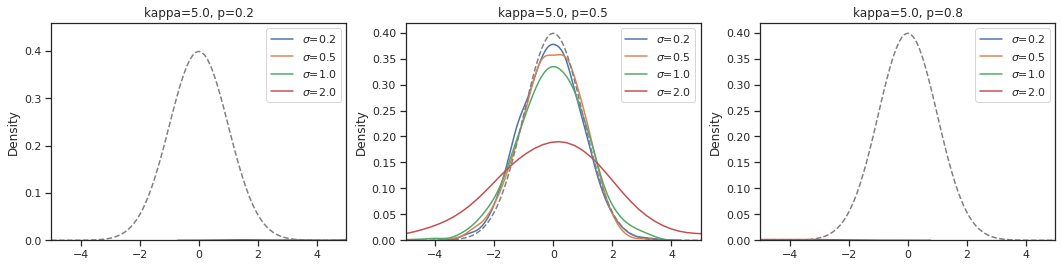

In [309]:
lim = 5

for kappa in kappas:
    
    fig, ax = plt.subplots(ncols=3, figsize=(18,4))

    for i, p in enumerate(ps):
       
        ax[i].set_xlim((-lim, lim))

        for sigma in sigmas:

            theta = 1 - (2 - phi) / 4 / (1 - phi)

            beta = kappa * (1 + sigma ** 2 - (2*p-1)**2) * (2-phi)**2 / 8 / Rx / Ry
            nu = 4 * (2*p - 1) * np.sqrt(Rx*Ry) / (1 + sigma ** 2 - (2*p-1)**2) / (2-phi)
            xi = np.sqrt(kappa * (1 + sigma ** 2 - (2*p-1)**2)) * (2-phi) / 2 / np.sqrt(Rx*Ry)

            Z0 = np.sqrt(Rx/Ry)
            mean = 2*theta - 1 + 2*theta*beta*nu*T/Z0
            var = 4 * theta**2 * xi**2 * T / Z0**2

            rs = (results[(kappa, sigma, p)] - mean) / np.sqrt(var)
            sns.kdeplot(rs, ax=ax[i], label=f"$\sigma$={sigma}")
            
        xs = np.linspace(-lim, lim, 101)
        ys = norm.pdf(xs)
        
        ax[i].set_title(f"kappa={kappa}, p={p}")
        ax[i].plot(xs, ys, linestyle='--', c='grey')
        ax[i].legend()